In [2]:
!pip install wandb

import pandas as pd
import utils

a. Select one dataset (you can choose any of one of your three datasets)


In [3]:
df = pd.read_csv("Preprocessed data - Heart Failure", index_col=0)
# df = pd.read_csv("Preprocessed data - Apartments for Rent Dataset", index_col=0)
# df = pd.read_csv("Preprocessed data - TV News Channel Commercial Detection Dataset", header=None)
df.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,diabetes,high_blood_pressure,sex,smoking,ground_truth
0,1.192945,0.000166,-1.530560,1.681648e-02,0.490057,-1.504036,-1.629502,0,0,1,1,0,1
1,-0.491279,7.514640,-0.007077,7.535660e-09,-0.284552,-0.141976,-1.603691,0,0,0,1,0,1
2,0.350833,-0.449939,-1.530560,-1.038073e+00,-0.090900,-1.731046,-1.590785,0,0,0,1,1,1
3,-0.912335,-0.486071,-1.530560,-5.464741e-01,0.490057,0.085034,-1.590785,1,0,0,1,0,1
4,0.350833,-0.435486,-1.530560,6.517986e-01,1.264666,-4.682176,-1.577879,1,1,0,0,0,1


b. For every algorithm (other than k-means) select the run with the hyper-parameter setting that creates the most similar number of clusters as the one found in question 5 above.

In [4]:
# Heart Failure
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering

X = df.iloc[:, :-1]
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k)
kmeans_labels = kmeans.fit_predict(X)
# Agglomerative hyper-parameter: n_clusters
n_clusters = optimal_k
agglo = AgglomerativeClustering(n_clusters=n_clusters)
agg_labels = agglo.fit_predict(X)
# OPTICS hyper_parameter: min_samples
min_samples = 7
optics = OPTICS(min_samples=min_samples)
opt_labels = optics.fit_predict(X)
# dbscan hyper_parameter: epsilon
eps = 1.3
dbscan = DBSCAN(eps=eps)
db_labels = dbscan.fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [24]:
# # TV Channels networks
# from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering

# df_sampled = df.groupby(10, group_keys=False).apply(lambda x: x.sample(frac=0.33, random_state=42))
# X = df_sampled.iloc[:, :-1]
# optimal_k = 2
# kmeans = KMeans(n_clusters=optimal_k)
# kmeans_labels = kmeans.fit_predict(X)
# # Agglomerative hyper-parameter: n_clusters
# n_clusters = optimal_k
# agglo = AgglomerativeClustering(n_clusters=n_clusters)
# agg_labels = agglo.fit_predict(X)
# # OPTICS hyper_parameter: min_samples
# min_samples = 70
# optics = OPTICS(min_samples=min_samples)
# opt_labels = optics.fit_predict(X)
# # dbscan hyper_parameter: epsilon
# eps = 0.1
# dbscan = DBSCAN(eps=eps)
# db_labels = dbscan.fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


c. Compare the selected clustering results using the adjusted rand index and comparison matrix (4 X 4) using clustering heat-map

In [5]:
from sklearn.metrics import adjusted_rand_score
import numpy as np

comparison_matrix = np.zeros((4, 4))

algo_label_pairs = (('KMeans', kmeans_labels), ('DBSCAN', db_labels),
 ('Agglomerative', agg_labels), ('OPTICS', opt_labels))

for i, (algorithm_i, algo_labels_i) in enumerate(algo_label_pairs):
    for j, (algorithm_j, algo_labels_j) in enumerate(algo_label_pairs):
        comparison_matrix[i, j] = adjusted_rand_score(algo_labels_i, algo_labels_j )

comparison_matrix

array([[ 1.        , -0.0020313 ,  0.26458723, -0.00697191],
       [-0.0020313 ,  1.        , -0.02648125, -0.02703683],
       [ 0.26458723, -0.02648125,  1.        , -0.05456507],
       [-0.00697191, -0.02703683, -0.05456507,  1.        ]])

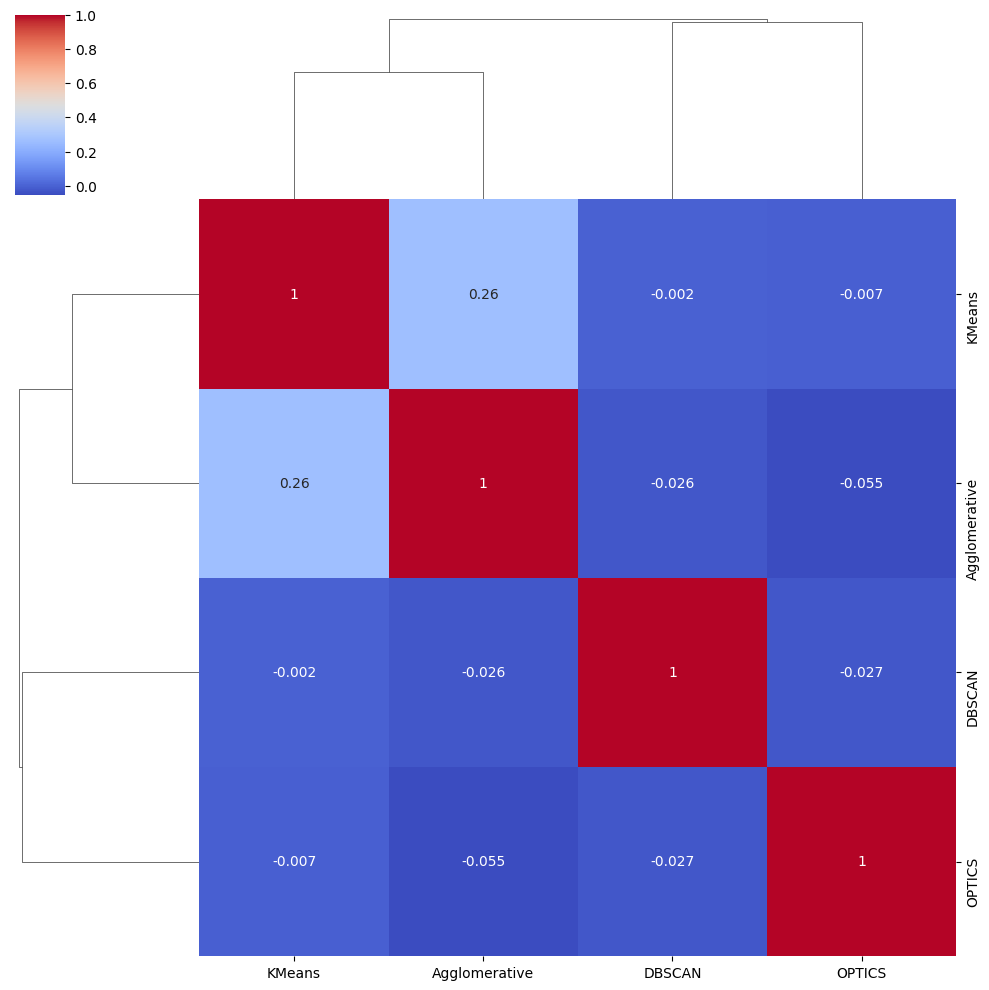

In [6]:
from seaborn import clustermap
import matplotlib.pyplot as plt

algo_names = [name for name, _ in algo_label_pairs]
clustermap(comparison_matrix, annot=True, cmap="coolwarm",
           xticklabels=algo_names,
           yticklabels=algo_names)
plt.show()

According to the ARI results there is a weak correlation between the clustering results of the Agglomerative algorithm and the optimal KMeans solution. DBScan and OPTICS algorithms have no correlation between their clustering results and the results of other models

d. For each clustering create a corresponding co-occurrence matrix based on the  cluster assignment of the samples.

In [14]:
n_samples = X.shape[0]
co_occurrence_matrix = np.zeros((n_samples, n_samples, 3), dtype=int)
labels = [algo_labels for _, algo_labels in algo_label_pairs]

for k in range(3):
    for i in range(n_samples):
        for j in range(i, n_samples):
            if labels[0][i] == labels[k+1][j]:
                co_occurrence_matrix[i, j, k] += 1
                co_occurrence_matrix[j, i, k] += 1

In [15]:
from sklearn.preprocessing import MinMaxScaler

normalized_matrices = np.zeros_like(co_occurrence_matrix, dtype=float)
for i in range(co_occurrence_matrix.shape[2]):
    scaler = MinMaxScaler()
    normalized_matrices[:, :, i] = scaler.fit_transform(co_occurrence_matrix[:, :, i])

e. Aggregate the co-occurrence matrix into one matrix (which will be used as  an affinity matrix)

In [16]:
affinity_matrix = np.mean(co_occurrence_matrix, axis=2)
affinity_matrix.shape

(299, 299)

f.  Perform a meta-clustering using a clustering algorithm of your choice that can receive a precomputed affinity matrix

In [22]:
from sklearn.cluster import SpectralClustering

meta_labels = SpectralClustering(n_clusters=2, affinity='precomputed', random_state=42).fit_predict(affinity_matrix)
meta_labels.shape

(299,)

Repeat step c by adding the result of step f (note the comparison matrix is now 5 X 5) and report your conclusions.

In [25]:
comparison_matrix = np.zeros((5, 5))

algo_label_pairs = (('KMeans', kmeans_labels), ('DBSCAN', db_labels),
 ('Agglomerative', agg_labels), ('OPTICS', opt_labels), ('Ensamble', meta_labels))

for i, (algorithm_i, algo_labels_i) in enumerate(algo_label_pairs):
    for j, (algorithm_j, algo_labels_j) in enumerate(algo_label_pairs):
        comparison_matrix[i, j] = adjusted_rand_score(algo_labels_i, algo_labels_j )

comparison_matrix

array([[ 1.        , -0.0020313 ,  0.26458723, -0.00697191,  0.45842185],
       [-0.0020313 ,  1.        , -0.02648125, -0.02703683, -0.009644  ],
       [ 0.26458723, -0.02648125,  1.        , -0.05456507,  0.68646199],
       [-0.00697191, -0.02703683, -0.05456507,  1.        , -0.02423575],
       [ 0.45842185, -0.009644  ,  0.68646199, -0.02423575,  1.        ]])

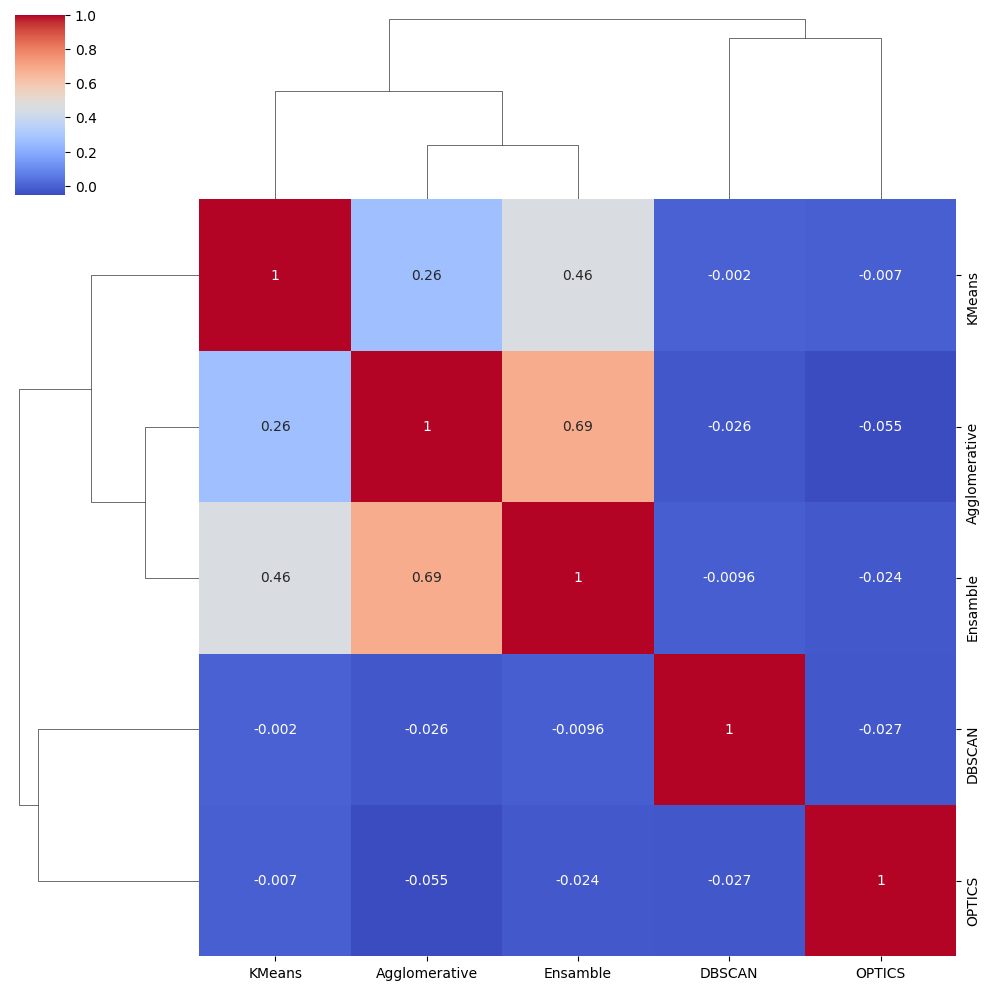

In [26]:
algo_names = [name for name, _ in algo_label_pairs]
clustermap(comparison_matrix, annot=True, cmap="coolwarm",
           xticklabels=algo_names,
           yticklabels=algo_names)
plt.show()

The ensemble clustering algorithm has very strong correlation with the agglomerative results and decent correlation with the optimal KMeans clustering solution.